In [ ]:
%pip install accelerate peft bitsandbytes transformers trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 13.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64

In [ ]:
#pip install --upgrade torch torchvision

In [ ]:
#pip install tensorboardX

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

### Data Processing

In [ ]:
filename = "all-data.csv"

df = pd.read_csv(filename,
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment],
                                    train_size=300,
                                    test_size=300,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1),
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

### Evaluation

In [ ]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

### Base Model Inference

In [ ]:
model_name = "NousResearch/Meta-Llama-3-8B"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 2048
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
tokenizer.pad_token_id = tokenizer.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 1,
                       )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

In [ ]:
y_pred = predict(test, model, tokenizer)

100%|██████████| 900/900 [02:23<00:00,  6.29it/s]


In [ ]:
evaluate(y_true, y_pred)

Accuracy: 0.359
Accuracy for label 0: 0.067
Accuracy for label 1: 0.467
Accuracy for label 2: 0.543

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.07      0.12       300
           1       0.30      0.47      0.37       300
           2       0.39      0.54      0.46       300

    accuracy                           0.36       900
   macro avg       0.52      0.36      0.32       900
weighted avg       0.52      0.36      0.32       900


Confusion Matrix:
[[ 20 186  94]
 [  2 140 158]
 [  1 136 163]]


### Fine-tuning

In [ ]:
from transformers import TrainerCallback

class EpochLossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.epoch_train_losses = []
        self.epoch_eval_losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Append the loss at the end of each epoch
        # Assuming the Trainer logs `loss` and `eval_loss` appropriately
        if state.log_history:
            # Extract the last recorded training and validation losses
            train_loss = next((x for x in reversed(state.log_history) if 'loss' in x), None)
            eval_loss = next((x for x in reversed(state.log_history) if 'eval_loss' in x), None)
            if train_loss:
                self.epoch_train_losses.append((state.epoch, train_loss['loss']))
            if eval_loss:
                self.epoch_eval_losses.append((state.epoch, eval_loss['eval_loss']))

# Instantiate the epoch-wise logging callback
epoch_loss_logging_callback = EpochLossLoggingCallback()


In [ ]:
output_dir="trained_weigths"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=10,                       # number of training epochs
    per_device_train_batch_size=2,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=False,             # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="epoch"               # save checkpoint every epoch
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    },
    callbacks=[epoch_loss_logging_callback]  # Use the epoch-wise callback
)


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [16]:
import matplotlib.pyplot as plt

# Train the model
trainer.train()

# Plotting
epochs_train, losses_train = zip(*epoch_loss_logging_callback.epoch_train_losses)
epochs_eval, losses_eval = zip(*epoch_loss_logging_callback.epoch_eval_losses)


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
0,0.907900,0.828977
1,0.774100,0.822666
2,0.602900,0.899225
4,0.248000,1.119544
5,0.186200,1.243919
6,0.137500,1.304635
8,0.100800,1.517019
9,0.094800,1.529814


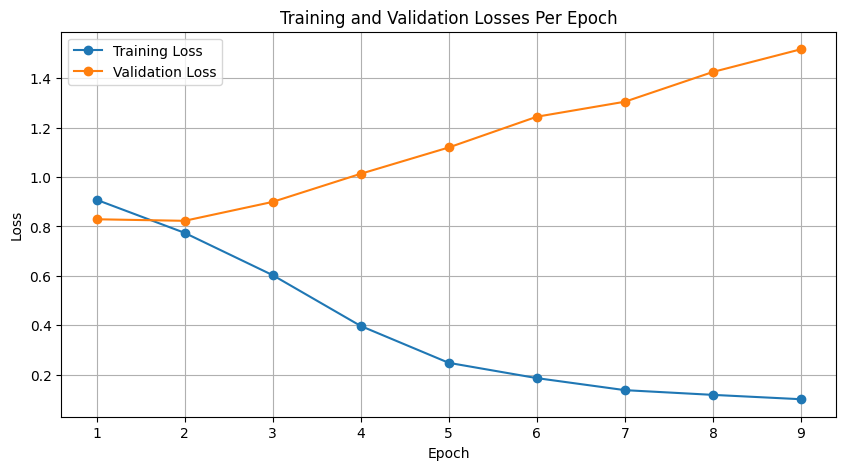

In [17]:


# Extracting the logged data
epochs, training_losses, validation_losses = zip(*[(x[0], x[1], y[1]) for x, y in zip(epoch_loss_logging_callback.epoch_train_losses, epoch_loss_logging_callback.epoch_eval_losses)])
epochs = np.arange(1, len(training_losses) + 1)
# Import matplotlib
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/tokenizer.json')

In [20]:
y_pred = predict(test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 900/900 [02:52<00:00,  5.20it/s]


Accuracy: 0.863
Accuracy for label 0: 0.927
Accuracy for label 1: 0.823
Accuracy for label 2: 0.840

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       300
           1       0.79      0.82      0.81       300
           2       0.85      0.84      0.85       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900


Confusion Matrix:
[[278  18   4]
 [ 14 247  39]
 [  2  46 252]]


In [21]:
evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

In [22]:
from google.colab import runtime
runtime.unassign()

In [ ]:
shutdown_kernel()